# Introduction
Branches in CPU instructions are often a major reason for performance hits as work done in parts of the CPU pipeline has to be discarded and the target instruction address of the branch has to be calculated and fetched. As modern pipelines get more complicated, the slow down caused by branches increases. There are many different ways to lessen the impact of branching, such as a branch delay slot, multiple instruction streams and branch prediction. 

In this practical, we focus on different branch prediction strategies by writing a branch predictor simulator to simulate the strategies over a series of execution traces from benchmark programs and calculate the prediction rates. The results are then presented and analysed to understand the effectiveness of different strategies on different types of programs. 

The following branch prediction strategies were simulated and analysed:
- Always taken
- Always not taken
- 2-bit predictor
- Correlating predictor
- Gshare
- Profiled approach

# Design 

## Benchmark programs
It is important to have a set of benchmarks with varied behaviour to understand the differences in the different branch prediction strategies. I have chosen seven benchmarks to try and get varied behaviour. Three of the benchmarks are from [SciMark2.0](http://math.nist.gov/scimark2/index.html) which are numeric and scientific calculations. The other benchmarks were written by myself to try and get different behaviours. The SciMark benchmarks are more complicated with many operations while mine are simple and more isolated in the kind of operations being done. This gives a variance between complex programs to understand how well each prediction strategy performs in general and the simple programs to isolate specific behaviour. All benchmark programs are written in C. Below is an overview of each benchmark:

| Benchmark | Description | Input |
|------|------|------|
|   FFT  | Taken from SciMark, this benchmark performs a one-dimensional forward transform of N complex numbers with complex arithmetic, shuffling, non-constant memory references and trigonometric functions. | N complex numbers (must be a power of 2) and M cycles.|
| MonteCarlo | Taken from SciMark, this benchmark approximates the value of Pi with random numbers which adds an element of random number generation | N the number of random numbers to be used|
| SOR | Taken from SciMark, this benchmark works on an NxN grid with operations on looping through and accessing neighbours | N the size of the grid and M cycles |
| Loop | This is a very simple benchmarks which only prints "Hello" N times. | N number of times to print |
| LoopCondition | This benchmark goes through a recursive function with conditionals where the value passed is changed until it reaches the base case | I an integer value to be used |
| BubbleSort | This is the classic bubble sort algorithm. It is methodic in the way it loops through the array to sort it, but as the array is randomly generated, the conditional will vary. | N the size of the array |

## Simulator implementation
Here is a brief overview of the implementation of the simulator.

In [2]:
from enum import Enum

class Branch(Enum):
    NOT_TAKEN = 0
    TAKEN = 1

The `Branch` enum represents whether the branch was taken or not. An enum is used instead of 0 and 1 to make it clear and avoid mistakes and errors.


In [3]:
class Step:
    def __init__(self, address, branch):
        self.address = address
        self.branch = branch
        
    def __repr__(self):
        return "(Address: " + str(self.address) + " , Branch: " + str(self.branch.name) + ")"

`Step` contains the address of the instruction and whether or not that branch was taken - stored in `self.address` and `self.branch` respectively. This is the representation of each step of the execution trace.

In [4]:
from abc import ABC, abstractmethod

class Predictor(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def predict_correct(self, step):
        pass
    
    def translate_address(self, address, table_bits):
        mask = 2 ** table_bits - 1
        return int(address) & mask
    
    def simulate(self, execution):
        correct_prediction_count = 0

        for step in execution:
            if self.predict_correct(step):
                correct_prediction_count += 1

        return correct_prediction_count / len(execution) * 100

The `Predictor` is the abstract class that our branch prediction strategies will extend. There are a few common functions defined here:
- `predict_correct` function will take a step in the execution and return whether or not the predictor predicted correctly. The function also updates the predictor's strategy accordingly, for example updating the history bits.
- `translate_address` applies a mask to the given address to get the bottom portion of the address within the table size.
- `simulate` will take the entire execution trace and return the percentage of correct branches that the predictor predicted.


## Branch prediction strategies

### Always taken and Always not taken

Always taken and always not taken are the simplest strategies and do as their names suggest. No logic is required as they simply return the same prediction every time.

In [5]:
class AlwaysTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

In [6]:
class AlwaysNotTakenPredictor(Predictor):
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        
    def predict_correct(self, step):
        return self.prediction == step.branch

### Two-bit predictor

The two-bit predictor uses two bits as history bits. The prediction is based off the most significant bit of the counter. The history serves as an indicator as to the recent behaviour of the branch (i.e, if the branch was taken the last few times, it will likely be taken again so predict that it is taken). Having two bits allows for some leeway if the branch 

![Two-bit predictor](imgs/TwoBitPredictor.jpg)

The two-bit predictor includes a branch history table for addresses to index into to take into account the local history of each branch. The lower bits of the branch address is chosen as an index rather than the higher bits because they are more likely to be different and therefore less likely to collide.

In [7]:
class TwoBitCounter():
    def __init__(self):
        self.prediction = Branch.NOT_TAKEN
        self.history_bits = (0, 0)
        
    def update(self, prediction_correct):
        self.update_bits(prediction_correct)
        
        if self.history_bits[0]:
            self.prediction = Branch.TAKEN
        else:
            self.prediction = Branch.NOT_TAKEN
            
    def update_bits(self, prediction_correct):
        prediction_value = self.prediction.value
        
        if (prediction_correct):
            self.history_bits = (prediction_value, prediction_value)
        else:
            last_bit = self.history_bits[1]
            self.history_bits = (last_bit, int(not prediction_value))

`TwoBitCounter` is the saturating counter that keeps track of the recent behaviour of the branch. To change a prediction, two consecutive misses have to be recorded. An important point to notice is that by default, the prediction is set to `Branch.NOT_TAKEN`. This is done deliberately because of the additional cost of computing the branch target address. It is less costly to continue the next instruction in sequence rather than assume and calculate the address of the taken branch.

In [8]:
class TwoBitPredictor(Predictor):
    def __init__(self, table_bits):
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.table[address]
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        return prediction_correct

The `TwoBitPredictor` fetches the corresponding two bit counter from its predictor table by indexing with the branch address. It can then predict based on the counter and update the counter afterwards with the actual direction the branch took.

### Correlating predictor

The correlating predictor lets us have multiple two-bit counters per branch. A history shift register will tell the predictor which counter to choose for each branch. This strategy takes into account the global history - the shift register - rather than just the local history of each branch. Depending on the global history of the shift register, it indexes to different two-bit counters on the same branch. This approach also lowers the chance of two addresses overwriting each other's counters when they collide. This is because the two addresses would have had to have the same global history to overwrite the same saturating counter.

In [9]:
class CorrelatingCounter():
    def __init__(self, register_bits):
        self.two_bit_counters = [TwoBitCounter() for i in range(2 ** register_bits)]

    def prediction(self, shift_register):
        counter = self.two_bit_counters[shift_register]
        return counter.prediction
    
    def update(self, prediction_correct, shift_register):
        counter = self.two_bit_counters[shift_register]
        counter.update(prediction_correct)

The `CorrelatingCounter` must have 2<sup>n</sup> `TwoBitCounter`s where *n* is the number of bits in the shift register. To get a prediction, the shift register must be passed so we can fetch the corresponding two-bit counter in the list. 

In [10]:
class CorrelatingPredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a CorrelatingCounter for each entry in the table
        inner_predictors = enumerate([CorrelatingCounter(register_bits) for i in range(2 ** table_bits)])
        self.table = {address: ip for (address, ip) in inner_predictors}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
    
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        inner_predictor = self.table[address]
        prediction = inner_predictor.prediction(self.shift_register)
        
        prediction_correct = prediction == step.branch
        inner_predictor.update(prediction_correct, self.shift_register)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1
        
        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)
            
    def simulate(self, execution):
        self.__init__(self.table_bits, self.register_bits)
        return super().simulate(execution)

The shift register represents the global history of the previous *n* branches where *n* is the number of bits in the shift register. The register is updated by bit shifting 1 to the right after every step. Then, if the branch was taken, add a 1 to the n<sup>th</sup> bit.

### Gshare

The Gshare predictor indexes by XORing the address and the shift register to index into the predictor table. It is a strategy proposed by McFarling to hash the global history (shift register) and branch address to gain more information than either alone. This approach as the same advantage of using the global history as part of the index to a saturating counter like the correlating predictor, but uses much less space. The correlating predictor uses an additional 2<sup>n</sup> counters for *n* bits in the shift register which is not needed in the gshare scheme.

In [11]:
class GsharePredictor(Predictor):
    def __init__(self, table_bits, register_bits):
        
        # Create a TwoBitCounter for each entry in the table
        counters = enumerate([TwoBitCounter() for i in range(2 ** table_bits)])
        self.table = {address: counter for (address, counter) in counters}
        self.table_bits = table_bits
        
        # Initialise shift register
        self.shift_register = 0b0
        self.register_bits = register_bits
        
    def predict_correct(self, step):
        address = self.translate_address(step.address, self.table_bits)
        counter = self.get_inner_predictor(address)
        prediction = counter.prediction
        
        prediction_correct = prediction == step.branch
        counter.update(prediction_correct)
        
        self.update_register(step.branch == Branch.TAKEN)
        
        return prediction_correct
    
    def get_inner_predictor(self, address):
        index = address ^ self.shift_register
        return self.table[index]
        
    def update_register(self, branch_taken):
        self.shift_register = self.shift_register >> 1

        if (branch_taken):
            self.shift_register |= 1 << (self.register_bits - 1)
            
    def simulate(self, execution):
        self.__init__(self.table_bits, self.register_bits)
        return super().simulate(execution)

## Profiled approach <a id='profiled_approach'></a>

# Experiments and results

## Benchmark branch properties

First, an overview of the branch properties of our benchmarks programs.


In [14]:
def get_unique_branches(trace):
    unique_branches = set([step.address for step in trace])
    return len(unique_branches)

def get_percentage_taken(trace):
    taken = 0
    
    for step in trace:
        if step.branch == Branch.TAKEN:
            taken += 1
            
    return taken / len(trace) * 100

def benchmark_properties(name, trace):
    unique_branches = get_unique_branches(trace)
    percentage_taken = get_percentage_taken(trace)
    total_length = len(trace)
    
    return str(name +  "\nTotal length: " + str(total_length) + "\nUnique branches: " + str(unique_branches) + 
                "\nPercentage taken: " + str(percentage_taken))

`benchmark_properties` can be passed a trace and return a the properties of the trace such as the number of unique branches and the total length of the trace. For example: 

In [15]:
print(benchmark_properties("Echo", trace_echo))

Echo
Total length: 48361
Unique branches: 2319
Percentage taken: 51.15692396765989


Below is a table which shows the branching properties of each benchmark. The three SciMark benchmarks `FFT`, `SOR` and `MonteCarlo` have a much higher percentage of branches taken compared to the other benchmarks. This is likely due to the lower amount of I/O and higher amount of calculations. We can see the `Loop` and `LoopCondition` programs, which output to console on every loop have a lower percentage of branches taken, similar to the `Echo` program. `BubbleSort` sits in the middle between the two extremes. It has many comparisons and operations to sort the list, but also I/O at the end of the program to output the sorted list. 

| Program | Total branches | Number of unique branches | % of branches taken |
| ------ | ----- | ----- |
| Echo | 48361 | 2319 | 51.16|
| FFT | 273784 | 2303 | 82.11 |
| SOR | 369432 | 2171 | 87.84 |
| MonteCarlo | 321653 | 2134 | 81.91 |
| Loop | 451068 | 1922 | 58.47 |
| LoopCondition | 66006 | 1999 | 53.45 |
| BubbleSort | 369764 | 2050 | 68.90 |

## Experiments

To start testing and experimenting with the branch trace files, we need to parse the execution trace file into a list of `Step`.

In [12]:
def createStep(address, taken_bit):
    if (taken_bit == '1'):
        return Step(address, Branch.TAKEN)
    else:
        return Step(address, Branch.NOT_TAKEN)

def parseTrace(file):
    lines = file.read().splitlines()
    steps = [line.split(" ") for line in lines]
        
    execution = [createStep(step[0], step[1]) for step in steps]
    return execution

`parseTrace` will return the execution trace as a list of steps that we can pass to our predictors. We can now parse all our benchmark traces.

In [13]:
trace_echo = parseTrace(open("traces/Echo.out", "r"))
trace_fft = parseTrace(open("traces/FFT8192.out", "r"))
trace_sor = parseTrace(open("traces/SOR200.out", "r"))
trace_mc = parseTrace(open("traces/MonteCarlo20000.out", "r"))
trace_loop = parseTrace(open("traces/Loop5000.out", "r"))
trace_cond = parseTrace(open("traces/LoopCondition.out", "r"))
trace_sort = parseTrace(open("traces/BubbleSort500.out", "r"))

Finally, we need some classes and functions to plot the graphs.

In [48]:
class PlotData():
    def __init__(self, trace, label, marker):
        self.trace = trace
        self.data = []
        self.label = label
        self.marker = marker

def new_benchmark_experiment():
    return {
        "Echo": PlotData(trace_echo, "Echo", "x"),
        "FFT": PlotData(trace_fft, "FFT", "o"),
        "SOR": PlotData(trace_sor, "SOR", "s"),
        "MC": PlotData(trace_mc, "MonteCarlo", "^"),
        "Loop": PlotData(trace_loop, "Loop", "p"),
        "Conditional": PlotData(trace_cond, "Conditional", "."),
        "BubbleSort": PlotData(trace_sort, "Bubble Sort", "*")
    }

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_graph(title, data, ylabel="Prediction rate", xlabel="History table size", xticks=[8, 512, 1024, 2048, 4096]):
    fig = plt.figure(figsize=(16,10))
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(xticks) 

    for d in data:
        plt.scatter(*zip(*d.data), marker=None)
        plt.plot(*zip(*d.data), label=d.label, marker=d.marker)
    plt.legend(loc="lower right")
    plt.ylim(top=100)
    plt.grid()
    return plt.axes()

For our initial experiments, we want to look at how each predictor performs against the benchmarks and see the kind of results and prediction rates we get. We first vary the address table size to see if it has an impact on performance. The larger the table size, the more addresses we can store and the less likely it would be for two addresses to collide and index into the same row of the table. Even though from our benchmark properties, we can see there is not more than 2500 unique addresses, having more table space is still important as some addresses could be very far from each other and have the same lower bits. Being able to index with more bits to lower the chance of this happening therefore should improve performance of all the predictors.

### Two bit predictor results

In [54]:
twobit_experiment = new_benchmark_experiment()

for i in range(1, 13):
    twobit_predictor = TwoBitPredictor(i)
    for k, v in twobit_experiment.items():
        v.data.append((len(twobit_predictor.table), twobit_predictor.simulate(v.trace)))

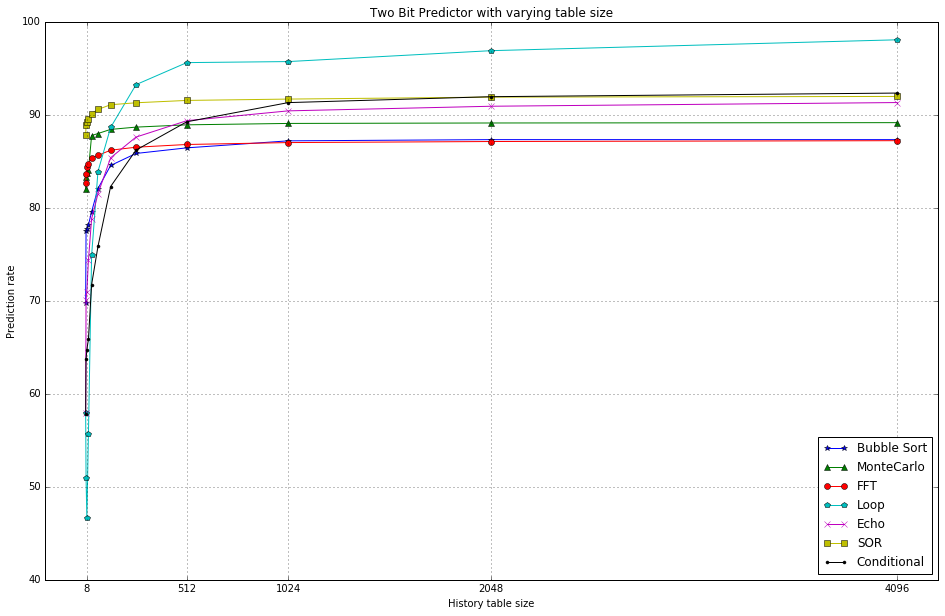

In [55]:
twobit_graph = plot_graph("Two Bit Predictor with varying table size", [data for _, data in twobit_experiment.items()])
twobit_graph.plot()
plt.show()

Recall that the three SciMark programs have a high percentage of branches taken and are more calculation and operation heavy. The two bit predictor graph shows these three benchmarks starting with a high prediction rate and not gaining much as the table size increases. This contrasts with the high I/O benchmarks such as `Loop` and `LoopCondition`. 

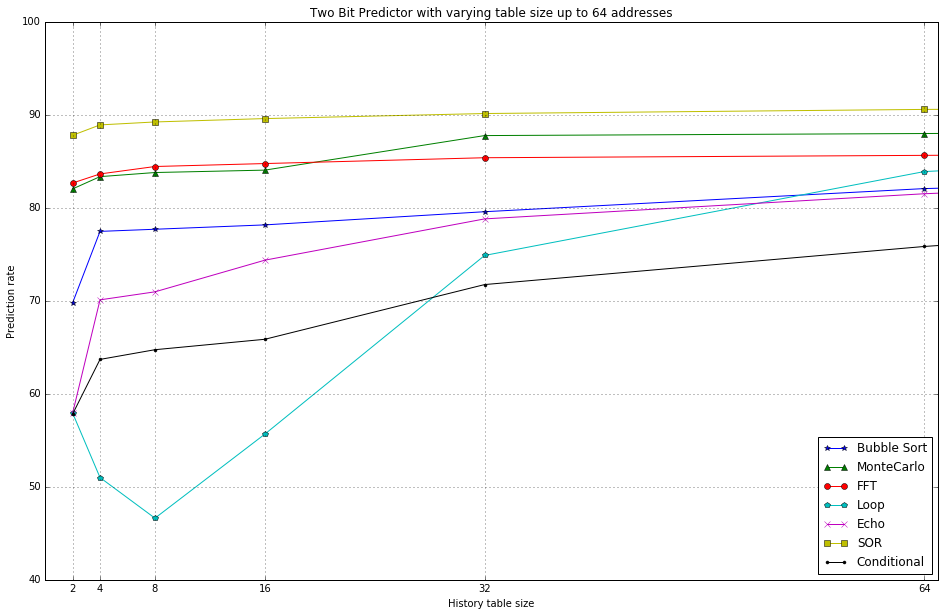

In [56]:
twobit_graph = plot_graph("Two Bit Predictor with varying table size up to 64 addresses", [data for _, data in twobit_experiment.items()], xticks=[2,4,8,16,32,64])
twobit_graph.plot()
plt.xlim(0,65)
plt.show()

The SciMark benchmarks start with a high prediction rate, even with only 2 or 4 entries in the predictor table. This may be related to their high percentage of branches taken (up to 87% for the `SOR` benchmark). Even with a small predictor table, if a large majority of branches follow the same pattern, performance is not greatly affected. This is also apparent as an increase in the table size does not lead to any significant increase in prediction rate. 

The `Loop` benchmark has an odd graph as its prediction rate initially goes down. The performance then vastly increases as the table size increases. This suggests the number of entries in the predictor history table is initially not enough to contain all the branches in one iteration of the loop, causing the saturing counters to be overwritten, leading to the low prediction rate. At 4 and 8 spaces in the table, the way the branches are addressed may line up just right such that the collisions lead to very poor performce. As the table size increases and conflicts decrease the problem is reduced until all branches of the loop can be stored concurrently in the history table. This can be seen when the increasing table size no longer yields a large increase in prediction rate.

We can see that the two bit predictor works well with branches which mostly go in one direction and this is shown from the SciMark benchmarks. The second bit provides resistance to a temporary change in the direction of the branch, allowing the predictor to continue to retain the main direction of the branch. However the predictor performs poorly when there is not a clear direction that a branch is heading. This is seen from the `Loop` benchmark when the entire loop could not be stored in the predictor table and collisions happen frequently. 

### Correlating predictor results

In [37]:
cp_experiment_twobits_history = new_benchmark_experiment()

for i in range(2, 13):
    cp = CorrelatingPredictor(i, 2)
    for k, v in cp_experiment_twobits_history.items():
        v.data.append((len(cp.table), cp.simulate(v.trace)))

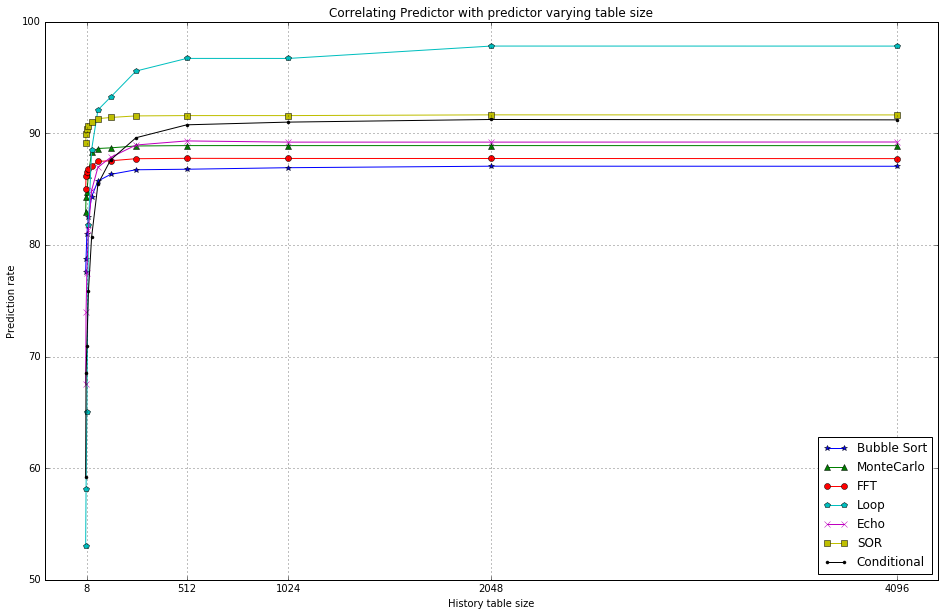

In [95]:
correlating_twobit_history_graph = plot_graph("Correlating Predictor with predictor varying table size", [data for _, data in cp_experiment_twobits_history.items()])
correlating_twobit_history_graph.plot()
plt.show()

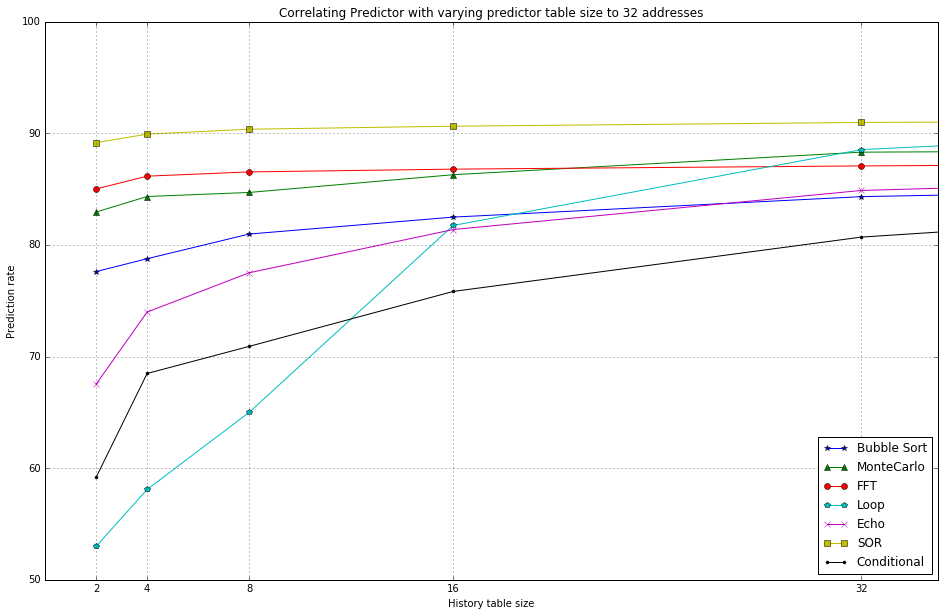

In [96]:
correlating_twobit_history_graph = plot_graph("Correlating Predictor with varying predictor table size to 32 addresses", [data for _, data in cp_experiment_twobits_history.items()], xticks=[2,4,8,16,32])
correlating_twobit_history_graph.plot()
plt.xlim(0, 35)
plt.show()

The results for the correlating predictor are initially similar to those for the two-bit predictor and often slightly better. All benchmarks except for the `Loop` benchmark start with a higher prediction rate.

| Benchmark | Two-bit predictor with 2 table addresses | Correlating predictor with 2 table addresses |
|  ---------| ----- | --------- |
|  Echo   |   57.89%   | 67.53% |
| FFT | 82.66% | 85.02% |
| SOR | 87.79% | 89.17% |
| MonteCarlo | 82.03% | 82.95% |
| Loop | 57.95% | 53.00% |
| Conditional | 57.81% | 59.18% |
| Bubble Sort | 69.77% | 77.62% |

<center> Table comparing prediction rates of two-bit predictor and correlating predictor with 2 table addresses </center>

With the shift register, the correlating predictor is able to overcome collisions better than the simple two bit predictor and therefore able to perform better at a lower number of table addresses. The trade-off here is the amount of memory the correlating predictor needs. It requires an additional *n* bits for the shift register and 2<sup>n</sup> - 1 saturating counters compared to the two bit predictor. In this case the shift register only has 2 bits so the trade-off may be worth it. For example for the `Echo` benchmark, the correlating predictor predicts 10% more branches correctly compared to the two bit predictor. On the other hand when we look at the prediction rates for 4096 addresses, they are very similar and the two bit predictor even does better on some benchmarks.

| Benchmark | Two-bit predictor with 4096 table addresses | Correlating predictor with 4096 table addresses |
|  ---------| ----- | --------- |
|  Echo   |  91.32%   | 89.23% |
| FFT | 87.22% | 87.74% |
| SOR | 91.97% | 91.66% |
| MonteCarlo | 89.16% | 88.90% |
| Loop | 98.01% | 97.82% |
| Conditional | 92.34% | 91.21% |
| Bubble Sort | 87.33% | 87.06% |

<center> Table comparing prediction rates of two-bit predictor and correlating predictor with 4096 table addresses </center>

The correlating predictor may perform better with more shift register bits, but that comes at an increased cost to memory.

### Gshare predictor results

In [98]:
gshare_experiment_twobits_history = new_benchmark_experiment()

for i in range(2, 13):
    gp = GsharePredictor(i, 2)
    for k, v in gshare_experiment_twobits_history.items():
        v.data.append((len(gp.table), gp.simulate(v.trace)))

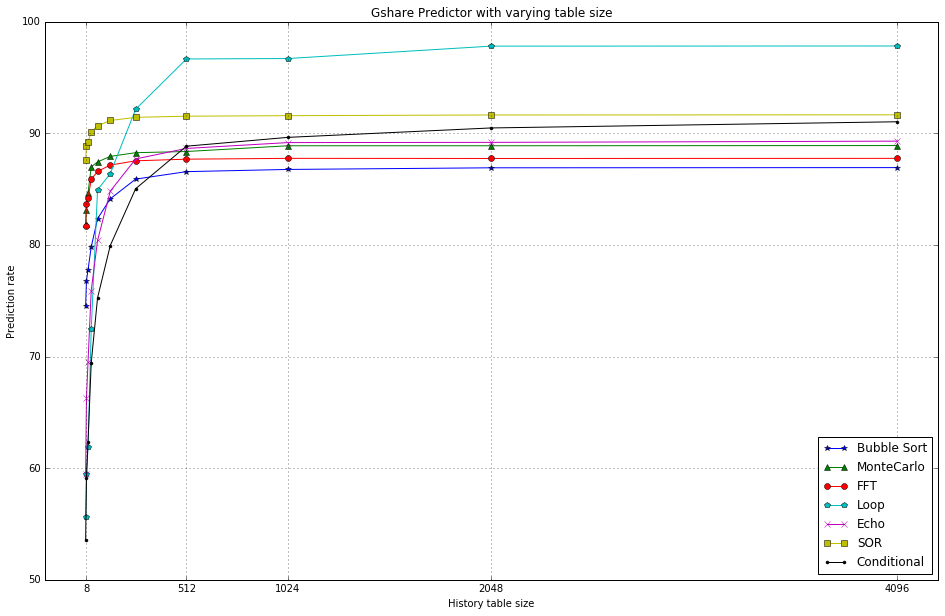

In [100]:
gshare_twobit_history_graph = plot_graph("Gshare Predictor with varying table size", [data for _, data in gshare_experiment_twobits_history.items()])
gshare_twobit_history_graph.plot()
plt.show()

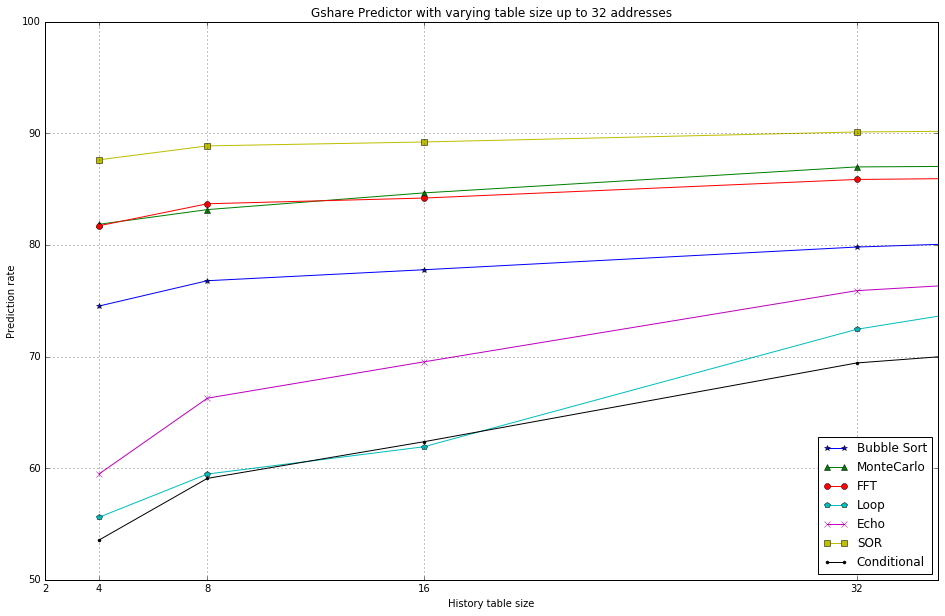

In [108]:
gshare_twobit_history_graph = plot_graph("Gshare Predictor with varying table size up to 32 addresses", [data for _, data in gshare_experiment_twobits_history.items()], xticks=[2,4,8,16,32])
gshare_twobit_history_graph.plot()
plt.xlim(2, 35)
plt.show()

Just like the results for the correlating predictor, we initially fix the shift register size to be 2 bits and see how the table size affects performance. 

Something more interesting to look at for correlating and gshare predictors is the number of bits we use for the shift register. The more bits used in the shift register, the more previous branches affect the current prediction. For example a shift register using 10 bits will use the history of the previous 10 branches to index into the predictor tables. Having more shift register bits may not always result in an increase in performance due if looking too far back in the history becomes irrelevant.

We use a smaller table size (256 addresses) for these results so there are intentionally more collisions. This allows us to see the effect of the shift register size clearer than if the performance increase had already begun to stagnate.


In [102]:
cp_experiment_256_addresses = new_benchmark_experiment()

for i in range(1, 9):
    cp = CorrelatingPredictor(8, i)
    for k, v in cp_experiment_256_addresses.items():
        v.data.append((i, cp.simulate(v.trace)))


<function matplotlib.pyplot.show>

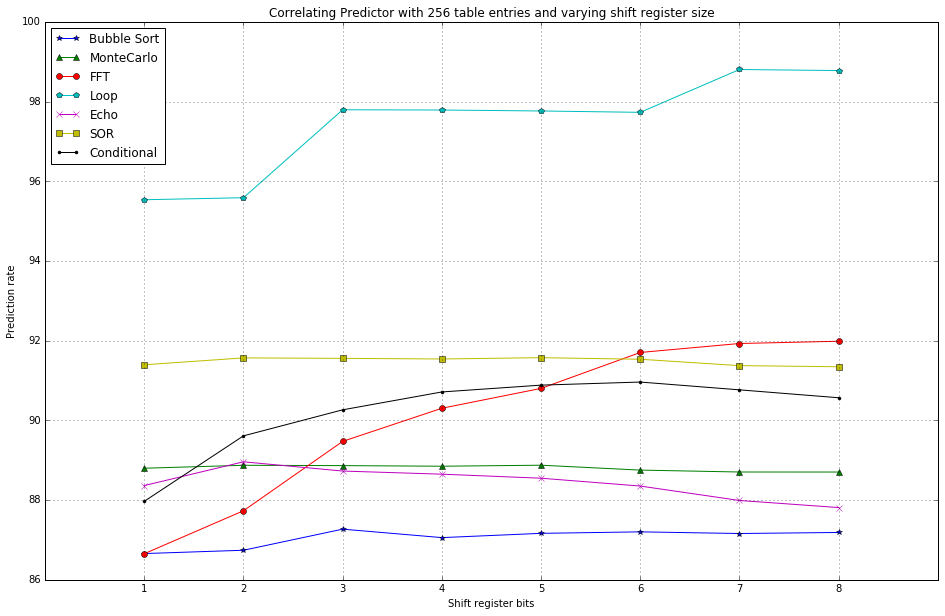

In [119]:
cp_256_addresses_graph = plot_graph("Correlating Predictor with 256 table entries and varying shift register size", 
                                    [data for _, data in cp_experiment_256_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8])
cp_256_addresses_graph.plot()
plt.legend(loc="best")
plt.xlim(0, 9)
plt.show

We can see with different benchmarks, the size of the register bits have a different affect. For example with `FFT` the performance continues to increase with the number of register bits, but for other benchmarks such as `Echo` have continually lower performance with more register bits. 

In [114]:
gp_experiment_512_addresses = new_benchmark_experiment()

for i in range(1, 10):
    gp = GsharePredictor(9, i)
    for k, v in gp_experiment_512_addresses.items():
        v.data.append((i, gp.simulate(v.trace)))


<function matplotlib.pyplot.show>

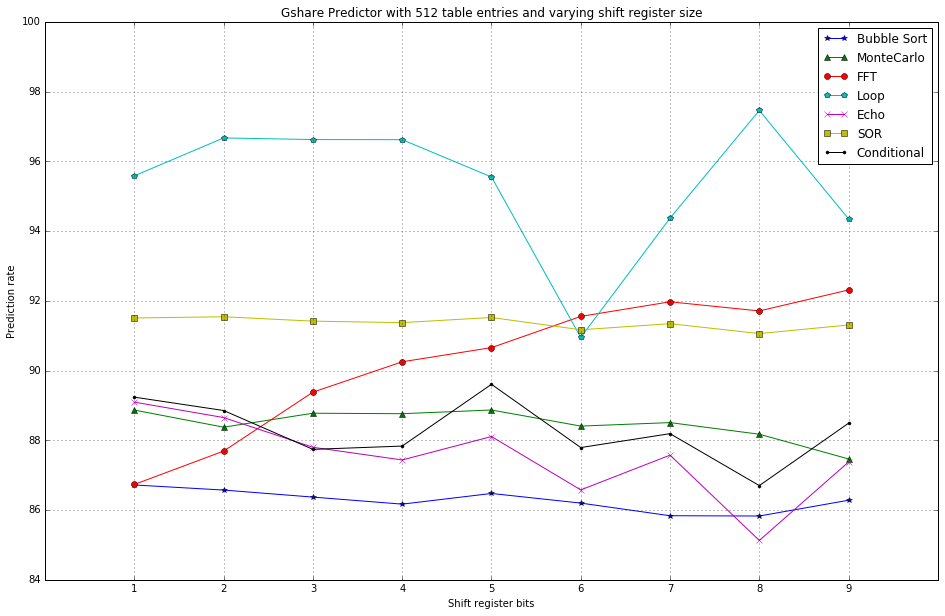

In [120]:
gp_512_addresses_graph = plot_graph("Gshare Predictor with 512 table entries and varying shift register size", 
                                    [data for _, data in gp_experiment_512_addresses.items()], 
                                    xlabel="Shift register bits", xticks=[1,2,3,4,5,6,7,8,9])
gp_512_addresses_graph.plot()
plt.legend(loc="best")
plt.xlim(0, 10)
plt.show

In [76]:
ee = {
    "128": PlotData(trace_sor, "SOR", "o"),
    "1024": PlotData(trace_sor, "SOR", "^")
}

In [77]:
for i in range(1, 8):
    g7 = GsharePredictor(7, i)
    ee["128"].data.append((i, g7.simulate(ee["128"].trace)))

In [78]:
for i in range(1, 8):
    g7 = GsharePredictor(10, i)
    ee["1024"].data.append((i, g7.simulate(ee["1024"].trace)))

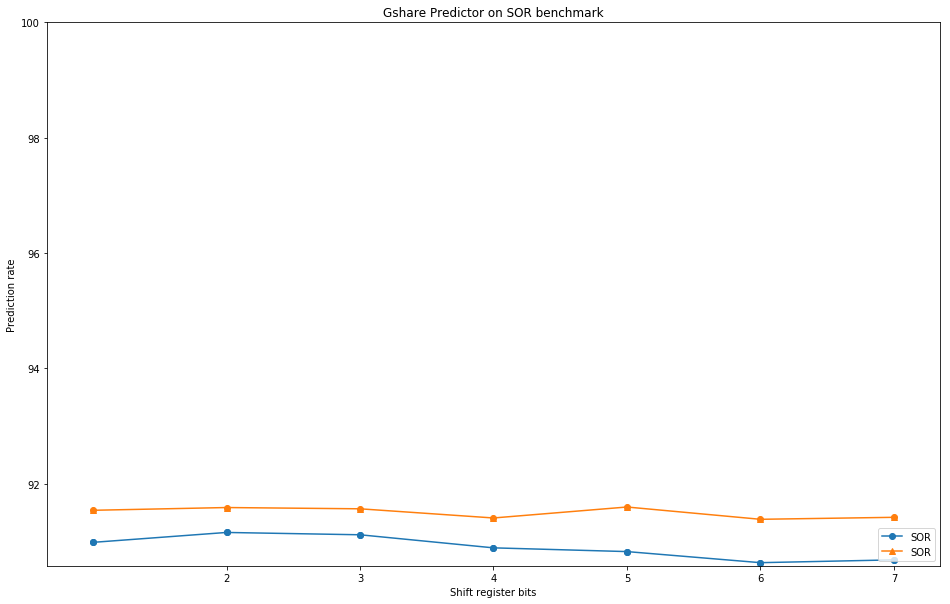

In [81]:
gge = plot_graph("Gshare Predictor on SOR benchmark", [data for _, data in ee.items()], xlabel="Shift register bits", xticks=[2,3,4,5,6,7,8,9,10,11,12])
gge.plot()
plt.show()

In [18]:
ge_graph = plot_graph("Gshare Predictor with 4k table entries", [data for _, data in ge.items()], xlabel="Shift register bits", xticks=[2,3,4,5,6,7,8,9,10,11,12])
e_graph.plot()
plt.legend(loc="best")
plt.xlim(1, 14)
plt.show

NameError: name 'ge' is not defined

# Conclusion

- more table size is generally better
- more register bits not necessarily better due to over-fitting (using too much history when it is no longer relevant)
- i/o requires more table size due to more branching and less pattern than calculation heavy benchmarks

# Further work

- branch properties of conditional/unconditional branches
- 

# References
- http://web.cs.ucdavis.edu/~su/Berkeley/cs252/project.html
- https://www2.eecs.berkeley.edu/Pubs/TechRpts/1983/CSD-83-121.pdf
- http://web.engr.oregonstate.edu/~benl/Projects/branch_pred/
- http://www.hpl.hp.com/techreports/Compaq-DEC/WRL-TN-36.pdf
- http://math.nist.gov/scimark2/about.html
- https://dl.acm.org/citation.cfm?id=192727
